In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('bmh')
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
import sklearn.model_selection as ms
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

pd.options.display.max_rows = 14

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
housing = pd.read_csv('housing.csv')
rn_train_set, rn_test_set = ms.train_test_split(housing, test_size = 0.2, random_state=42)
income_categories = housing['median_income'] // 1.5
income_categories[income_categories >= 5] = 5
split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for training_indices, test_indices in split.split(housing, income_categories):
    stratified_train_set = housing.loc[training_indices]
    stratified_test_set = housing.loc[test_indices]
housing_features = stratified_train_set.drop('median_house_value', axis=1)
housing_labels = stratified_train_set.median_house_value.copy()
imputer = Imputer(strategy='median')
housing_numeric = housing_features.drop('ocean_proximity', axis=1)
imputer.fit(housing_numeric)
imputer.statistics_
X = imputer.transform(housing_numeric)
housing_features_tr = pd.DataFrame(X, columns=housing_numeric.columns)
housing_categorical = housing_features['ocean_proximity']
%run 'CategoricalEncoder.py'
%run 'class.py'
numeric_cols = list(housing_numeric)
categorical_cols = ['ocean_proximity']
numeric_cols_pipeline = Pipeline([('selector', ColumnSelector(numeric_cols)),
                                  ('imputer', Imputer(strategy='median')),
                                  ('attributes_adder', AttributeAdder()),
                                  ('standard_scaler', StandardScaler())
                                 ])

categorical_cols_pipeline = Pipeline([('selector', ColumnSelector(categorical_cols)),
                                      ('encoder', CategoricalEncoder(encoding='onehot-dense'))
                                     ])

full_pipeline = FeatureUnion(transformer_list=[('numeric_pipeline', numeric_cols_pipeline),
                                               ('categorical_pipeline', categorical_cols_pipeline)
                                              ])
housing_transformed = full_pipeline.fit_transform(stratified_train_set)
housing_transformed

#linear regression
lin_reg = LinearRegression()
x = lin_reg.fit(housing_transformed, housing_labels)
housing_predictions = lin_reg.predict(housing_transformed)
h=list(housing_labels)
mean_squared_error(h,housing_predictions)
r2_score(h,housing_predictions)

#DecisionTree Regressor
dt_reg = DecisionTreeRegressor()
x = dt_reg.fit(housing_transformed, housing_labels)
housing_predictions2 = dt_reg.predict(housing_transformed)
train_mse2 = mean_squared_error(housing_labels, housing_predictions2)
np.sqrt(train_mse2)
r2_score(housing_labels, housing_predictions2)

#RandomForestRegressor
rf_reg = RandomForestRegressor()
x = rf_reg.fit(housing_transformed, housing_labels)
housing_predictions3 = rf_reg.predict(housing_transformed)
train_mse3 = mean_squared_error(housing_labels, housing_predictions3)
np.sqrt(train_mse3)
r2_score(housing_labels, housing_predictions3)

#cross validation
p=cross_val_score(dt_reg, housing_transformed, housing_labels, scoring='neg_mean_squared_error', cv=10)
np.sqrt(-p)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

array([ -118.52  ,    34.26  ,    29.    ,  2127.    ,   433.    ,
        1162.    ,   409.    ,     3.5417])

array([[ 0.55770877, -0.24384572, -1.00717954, ...,  0.        ,
         0.        ,  0.        ],
       [-2.23455235,  2.43896586,  0.18778414, ...,  0.        ,
         0.        ,  1.        ],
       [-0.54121332, -0.07061006, -0.92751529, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.62764017, -0.74014245,  1.8607333 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.70256668, -0.75887063,  0.42677688, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.58767937, -0.67927587,  0.1081199 , ...,  0.        ,
         0.        ,  0.        ]])

4623672637.8403139

0.65158541863086272

0.0

1.0

22225.741007861798

0.96277611113322425

array([ 70209.60354502,  74870.23056586,  71277.28241881,  71995.19563045,
        69129.88471908,  71249.74431856,  73571.40700822,  70551.13974104,
        76252.41870981,  66249.57380325])

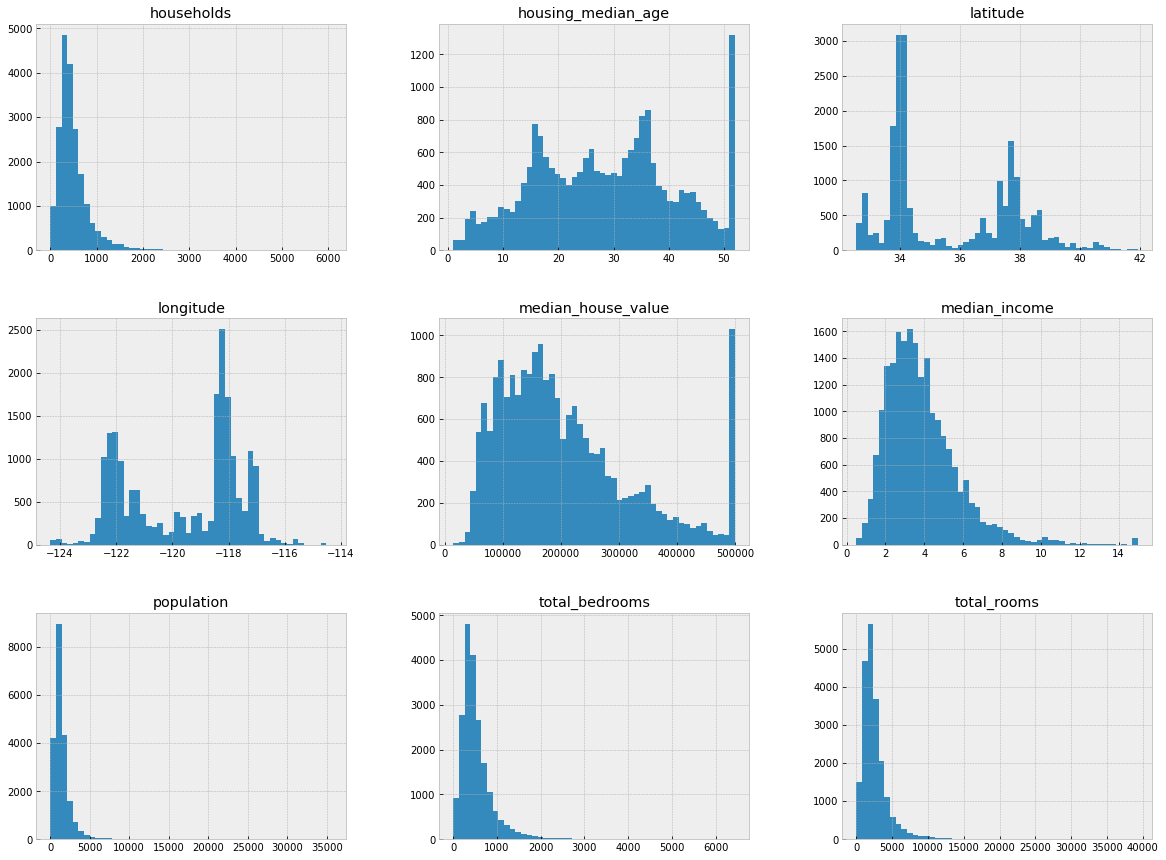

In [4]:
x = housing.hist(bins=50, figsize=(20, 15))
plt.show()

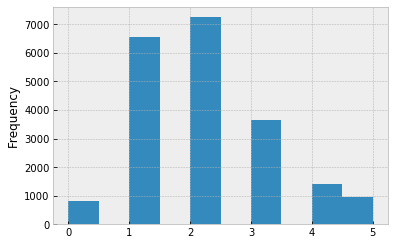

In [5]:
x = income_categories.plot(kind='hist')

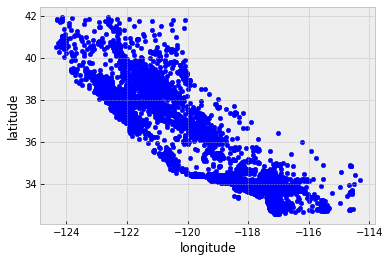

In [6]:
x = housing.plot(kind='scatter', x='longitude', y='latitude')

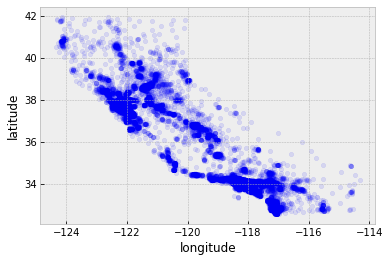

In [7]:
x = housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

In [8]:
corr_matrix = housing.corr()
corr_matrix = np.abs(corr_matrix)
corr_matrix = corr_matrix.median_house_value.sort_values(ascending=False)
corr_matrix

median_house_value    1.000000
median_income         0.688075
latitude              0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
longitude             0.045967
population            0.024650
Name: median_house_value, dtype: float64

In [9]:
corr_columns = corr_matrix.index[:5]
housing[corr_columns].head()

median_house_value  median_income  latitude  total_rooms  \
0            452600.0         8.3252     37.88        880.0   
1            358500.0         8.3014     37.86       7099.0   
2            352100.0         7.2574     37.85       1467.0   
3            341300.0         5.6431     37.85       1274.0   
4            342200.0         3.8462     37.85       1627.0   

   housing_median_age  
0                41.0  
1                21.0  
2                52.0  
3                52.0  
4                52.0

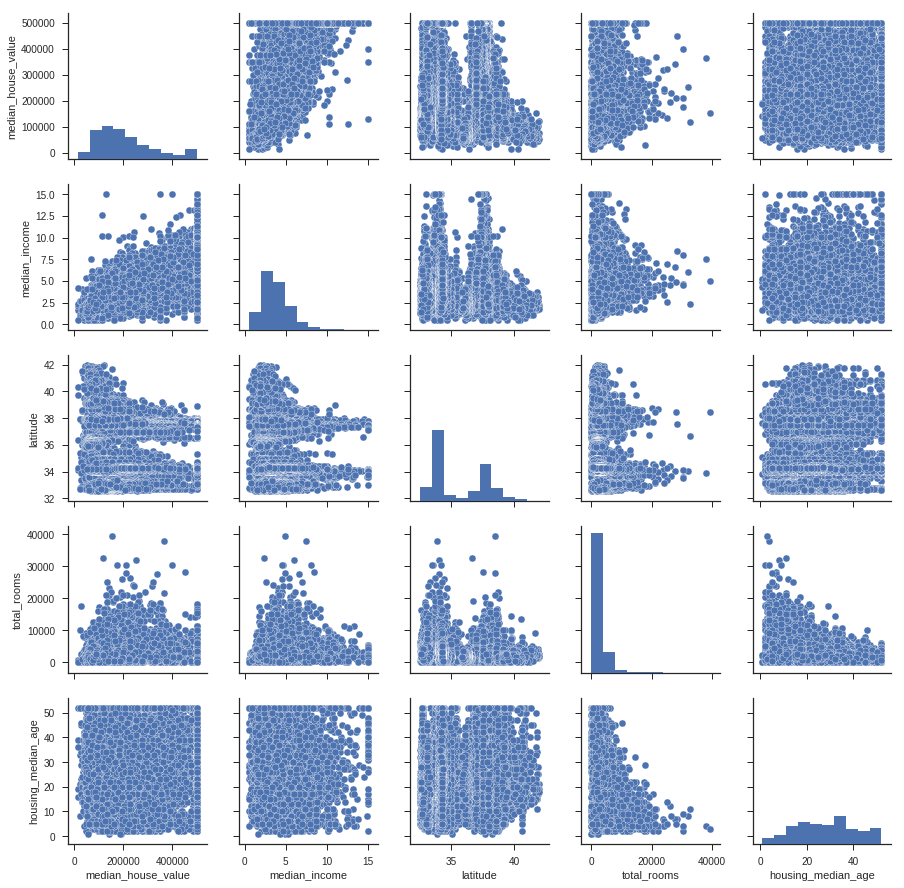

In [11]:
import seaborn as sns
sns.set(style='ticks')
x = sns.pairplot(housing[corr_columns])

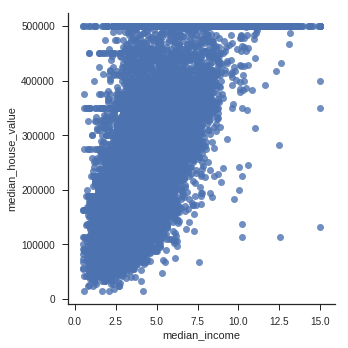

In [15]:
x = sns.lmplot('median_income', 'median_house_value', data=housing, fit_reg=False)

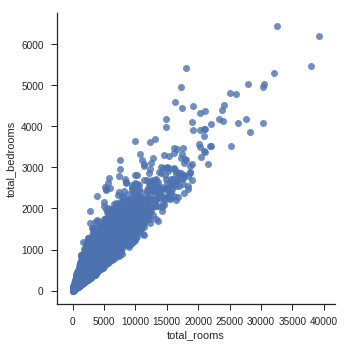

In [16]:
x = sns.lmplot('total_rooms', 'total_bedrooms', data=housing, fit_reg=False)

In [20]:
x = median_income.plot(kind='hist')

NameError: name 'median_income' is not defined

In [13]:
housing_features.dropna(subset=['total_bedrooms'])

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3153     -118.46     35.12                16.0       4084.0           812.0   
2579     -124.05     40.85                31.0       2414.0           428.0   
16718    -120.66     35.49                17.0       4422.0           945.0   
5373     -118.38     34.04                36.0       3005.0           771.0   
20311    -119.11     34.17                37.0        470.0           105.0   
1727     -122.37     37.96                37.0       1572.0           402.0   
1553     -121.98     37.80                17.0       3354.0           422.0   
...          ...       ...                 ...          ...             ...   
13893    -116.31     34.13                20.0       2352.0           556.0   
20015    -119.08     36.09                25.0       1880.0           339.0   
18879    -122.26     38.10                24.0       1213.0           395.0   
19612    -121.11     37.47                12.0       2263.0           410.0   
4624     -118.32     34.06                52.0        983.0           246.0   
7214     -118.17     34.02                34.0        760.0           219.0   
3734     -118.40     34.19                30.0        521.0           126.0   

       population  households  median_income ocean_proximity  
3153       2033.0       668.0         3.2405          INLAND  
2579       1005.0       401.0         3.5156      NEAR OCEAN  
16718      2307.0       885.0         2.8285       <1H OCEAN  
5373       2054.0       758.0         2.0437       <1H OCEAN  
20311       522.0        83.0         2.0368      NEAR OCEAN  
1727       1046.0       350.0         0.7403        NEAR BAY  
1553       1457.0       425.0         7.6473       <1H OCEAN  
...           ...         ...            ...             ...  
13893      1217.0       481.0         1.6063          INLAND  
20015      1003.0       315.0         2.7298          INLAND  
18879       699.0       386.0         1.3007        NEAR BAY  
19612       913.0       330.0         3.5795          INLAND  
4624        578.0       204.0         5.7393       <1H OCEAN  
7214        968.0       202.0         1.7813       <1H OCEAN  
3734        306.0       129.0         4.1125       <1H OCEAN  

[16359 rows x 9 columns]